In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint

## Generate rotated card

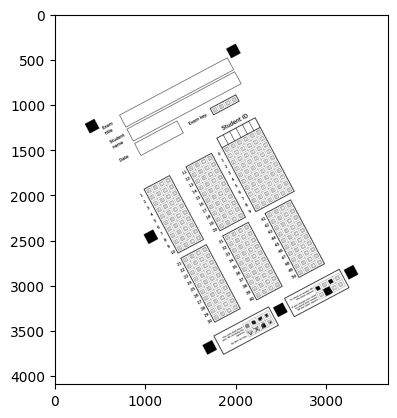

In [24]:
img = cv2.imread("svgtest.png")
angle = randint(-90, 90)

h, w = img.shape[:2]
cx, cy = (w // 2, h // 2)

# get rotation matrix (explained in section below)
M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)

# get cos and sin value from the rotation matrix
cos, sin = abs(M[0, 0]), abs(M[0, 1])

# calculate new width and height after rotation (explained in section below)
newW = int((h * sin) + (w * cos))
newH = int((h * cos) + (w * sin))

# calculate new rotation center
M[0, 2] += (newW / 2) - cx
M[1, 2] += (newH / 2) - cy

# use modified rotation center and rotation matrix in the warpAffine method
result = cv2.warpAffine(img, M, (newW, newH), borderMode=cv2.BORDER_CONSTANT,
                           borderValue=(255,255,255)) 

plt.imshow(result);

6


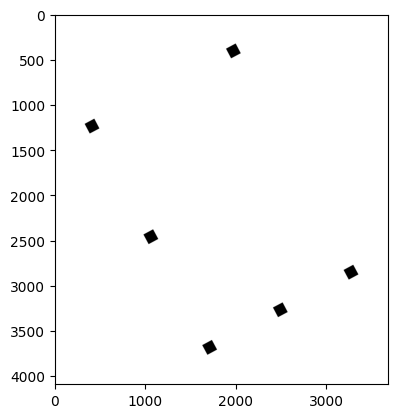

In [25]:
gray_image = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
mask = cv2.inRange(gray_image, 0, 150)

# apply morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# get external contours
contours = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

squares = []
for c in contours:
    # get rotated rectangle from contour
    rot_rect = cv2.minAreaRect(c)
    if abs(rot_rect[1][0] - rot_rect[1][1]) < min(rot_rect[1]) / 50:
        squares.append(rot_rect)

result1 = np.full_like(gray_image, fill_value=255)
for rect in squares:
    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
    box = np.int0(box)
    cv2.drawContours(result1, [box], 0, 0, -1)

plt.imshow(result1, cmap='gray', vmin=0, vmax=255)
print(len(squares))

In [44]:
def set_numeric_values_squares(contours):
    def calculate_delta(first_pos, second_pos):
        return abs(first_pos[0] - second_pos[0]), abs(first_pos[1] - second_pos[1])
    def is_similar(first_delta, second_delta):
        similarity_threshhold = min([min(first_delta), min(second_delta)]) / 50 
        return abs(first_delta[0] - second_delta[0]) < similarity_threshhold and \
               abs(first_delta[1] - second_delta[1]) < similarity_threshhold

    # Top       left: 5,                right: -
    # Middle    left: 4
    # Bottom    left: 1,    middle 2,   right: 3
    # Page width = distance between 1 and 3
    # Page height = distance between 1 and 5
    
    # Find three squares lines
    points = []
    for first_idx in range(len(contours)):
        first_point = contours[first_idx]
        for second_idx in range(first_idx + 1, len(contours)):
            second_point = contours[second_idx]
            for third_idx in range(second_idx + 1, len(contours)):
                third_point = contours[third_idx]
                fs_delta = calculate_delta(first_point[0], second_point[0])
                ft_delta = calculate_delta(first_point[0], third_point[0])
                st_delta = calculate_delta(second_point[0], third_point[0])
                if is_similar(fs_delta, st_delta):
                    points.append([first_point, second_point, third_point])
                elif is_similar(fs_delta, ft_delta):
                    points.append([second_point, first_point, third_point])  
                elif is_similar(st_delta, ft_delta):
                    points.append([first_point, third_point, second_point])
    
    first_line = points[0]
    second_line = points[1]

    if first_line[0] == second_line[0]:
        pass
    elif first_line[2] == second_line[2]:
        first_line = first_line[::-1] 
        second_line = second_line[::-1] 
    elif first_line[0] == second_line[2]:
        second_line = second_line[::-1]
    elif first_line[2] == second_line[0]:
        first_line = first_line[::-1]
    
    fl_x, fl_y = calculate_delta(first_line[0][0], first_line[2][0])
    sl_x, sl_y = calculate_delta(second_line[0][0], second_line[2][0])

    fl_dist = (fl_x ** 2 + fl_y ** 2) ** (1/2)
    sl_dist = (sl_x ** 2 + sl_x ** 2) ** (1/2)

    if fl_dist < sl_dist:
        horizontal_line = first_line
        vertical_line = second_line
    else:
        vertical_line = second_line
        horizontal_line = first_line
    numered_points = dict(enumerate([*horizontal_line, *vertical_line[1:]]))
    return numered_points


print(set_numeric_values_squares(squares))

[[((1710.0653076171875, 3684.923095703125), (120.14578247070312, 120.14578247070312), 61.99082565307617), ((2491.481201171875, 3269.4404296875), (120.151123046875, 120.13993835449219), 62.00285339355469), ((3272.88916015625, 2853.9580078125), (120.151123046875, 120.151123046875), 62.00285339355469)], [((1710.0653076171875, 3684.923095703125), (120.14578247070312, 120.14578247070312), 61.99082565307617), ((1059.8560791015625, 2462.038818359375), (120.151123046875, 120.151123046875), 62.00285339355469), ((409.6365966796875, 1239.16162109375), (120.13993835449219, 120.13993835449219), 62.00285339355469)]]
